In [2]:
import csv
import time
from pylsl import StreamInlet, resolve_byprop
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math

# CSVファイルにデータを保存する関数
def save_data_to_csv(start_time, timestamp, data, filename):
    fieldnames = ['timestamp', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # ヘッダーがない場合は、ヘッダーを書き込む
        csvfile.seek(0, 2)
        if csvfile.tell() == 0:
            writer.writeheader()

        # Start time subtraction for relative timestamps
        relative_timestamp = lsl_to_local_datetime(timestamp) - start_time
        row = {'timestamp': relative_timestamp.total_seconds()}
        row.update({fieldnames[i + 1]: data[i+3] for i in range(len(data)-5)})
        writer.writerow(row)
        
# マーカー付きデータをｃｓｖ保存
def save_data_to_csv_with_marker(start_time, timestamp, sample, marker, filename):
    # 開始と終了の3つの要素を削除し、タイムスタンプを0から始まるように修正
    sample = sample[3:-2]
    timestamp -= start_time
    
    # DataFrameを作成し、データを追記していく
    # sampleはリスト形式でデータが渡される
    # マーカーもこのDataFrameに格納
    # タイムスタンプを先頭に追加
    df = pd.DataFrame([[timestamp] + sample + [marker]])  

    with open(filename, 'a') as f:
        df.to_csv(f, header=f.tell() == 0, index=False, lineterminator='\n')  # headerはファイルの先頭だけに出力


#CSVファイルからデータを読み込む関数
def load_data_from_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)

    return data

# データをプロットする関数
def plot_data(data, channels):
    timestamps = [float(row['timestamp']) for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.legend()
    plt.show()
    
def plot_data_for_parallel(data, channels, title, subplot_position):
    plt.subplot(1, 2, subplot_position)
    time = np.arange(len(data)) / 256.0  # Create a time array (assuming data was collected at 256 Hz)

    for channel in channels:
        plt.plot(time, data[channel], label=channel)

    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    
    
# マーカー付きデータをプロットする関数
def plot_data_with_marker(data, channels):
    timestamps = [float(row['Timestamp']) for row in data]
    markers = [row['Marker'] for row in data]

    plt.figure(figsize=(15, 8))

    for channel in channels:
        values = [float(row[channel]) for row in data]
        plt.plot(timestamps, values, label=channel)

    # Add a vertical line at the marker position(s)
    marker_set = False
    for i, mark in enumerate(markers):
        if mark == '1' and not marker_set:  # Add marker only at first occurrence
            plt.axvline(x=timestamps[i], color='r', linestyle='--', label='Marker')
            marker_set = True
            
    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Sensor Value')
    plt.title('Brainwave Data')
    plt.show()

    
def lsl_to_local_datetime(lsl_timestamp):
    return datetime.fromtimestamp(lsl_timestamp)


# データの収集が開始されてから2秒間、カウントダウンを行う
# カウントダウンが終了した時点でマーカーを追加
# 256Hzで収集（デフォルト）
def collect_EEG(filename, duration):
    # EPOCXのストリームを探す
    streams = resolve_byprop('type', 'EEG', timeout=5)

    if not streams:
        raise RuntimeError("No EEG stream found. Make sure the EmotivPro LSL Connector is running.")

    # ストリームを開く
    inlet = StreamInlet(streams[0])

    print("Connected to Emotiv EPOCX stream.")

    # ファイルを上書きモードで開いてすぐ閉じることで、中身を空にする
    with open(filename, 'w') as f:
        # チャンネル名のラベルを設定
        header = ['Timestamp'] + ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] + ['Marker']
        f.write(','.join(header) + '\n')

    # データを取得し、CSVファイルに記録する
    start_time = None
    marker_set = False
    prev_printed_second = None

    #収集開始
    while True:
        sample, timestamp = inlet.pull_sample()
        if start_time is None:
            start_time = timestamp
        elapsed_time = timestamp - start_time
        
        # Print only if the rounded elapsed_time has changed
        rounded_elapsed_time = round(elapsed_time * 2) / 2  # Round to nearest 0.5
        if prev_printed_second is None or prev_printed_second != rounded_elapsed_time:
            prev_printed_second = rounded_elapsed_time
            if elapsed_time < 2:
                print(f"Countdown: {2 - elapsed_time:.2f}")
        
        if not marker_set and elapsed_time >= 2:
            print("Marker set.")
            marker_set = True
        marker = 1 if elapsed_time >= 2 else 0  # 2秒後にマーカーを設定
        save_data_to_csv_with_marker(start_time, timestamp, sample, marker, filename)  # マーカーの情報を含むように関数を修正
        if elapsed_time >= duration:
            break

    print("done.")
    return

Connected to Emotiv EPOCX stream.
Countdown: 2.0
Countdown: 1.9999495000010938
Countdown: 1.9999184999996942
Countdown: 1.984947099999772
Countdown: 1.984898599999724
Countdown: 1.984870399999636
Countdown: 1.9848448000011558
Countdown: 1.969869700000345
Countdown: 1.96780150000086
Countdown: 1.967764500001067
Countdown: 1.9677362000002177
Countdown: 1.9549349999997503
Countdown: 1.9548876000008022
Countdown: 1.9548623999999108
Countdown: 1.9399188999996113
Countdown: 1.9398777999995218
Countdown: 1.9398529999998573
Countdown: 1.939828900000066
Countdown: 1.9398041000004014
Countdown: 1.9249340999995184
Countdown: 1.92489150000074
Countdown: 1.9248674000009487
Countdown: 1.9099246999994648
Countdown: 1.9098792000004323
Countdown: 1.9078884000009566
Countdown: 1.907854999999472
Countdown: 1.8944093999998586
Countdown: 1.894367200000488
Countdown: 1.8943417999998928
Countdown: 1.8943175000003976
Countdown: 1.8798439000001963
Countdown: 1.8797974999997678
Countdown: 1.879769999999553
Coun

Countdown: 0.7676499000008334
Countdown: 0.7675970000000234
Countdown: 0.7675682999997662
Countdown: 0.7542682000002969
Countdown: 0.7542176999995718
Countdown: 0.7541899999996531
Countdown: 0.7541627999999037
Countdown: 0.7391786000007414
Countdown: 0.7391301000006933
Countdown: 0.7391024999997171
Countdown: 0.739076699999714
Countdown: 0.7242224000001443
Countdown: 0.7241723999995884
Countdown: 0.7222094999997353
Countdown: 0.7221741000012116
Countdown: 0.7091094000006706
Countdown: 0.7090623000003689
Countdown: 0.709035900001254
Countdown: 0.7090109000000666
Countdown: 0.6951563000002352
Countdown: 0.6951100999995106
Countdown: 0.6950823000006494
Countdown: 0.6800237000006746
Countdown: 0.6799718000002031
Countdown: 0.679942700000538
Countdown: 0.6799162999996042
Countdown: 0.6650220000010449
Countdown: 0.664975300000151
Countdown: 0.6649486999995133
Countdown: 0.6625793000002886
Countdown: 0.6496232999998028
Countdown: 0.6495754000006855
Countdown: 0.6495305000007647
Countdown: 0.6

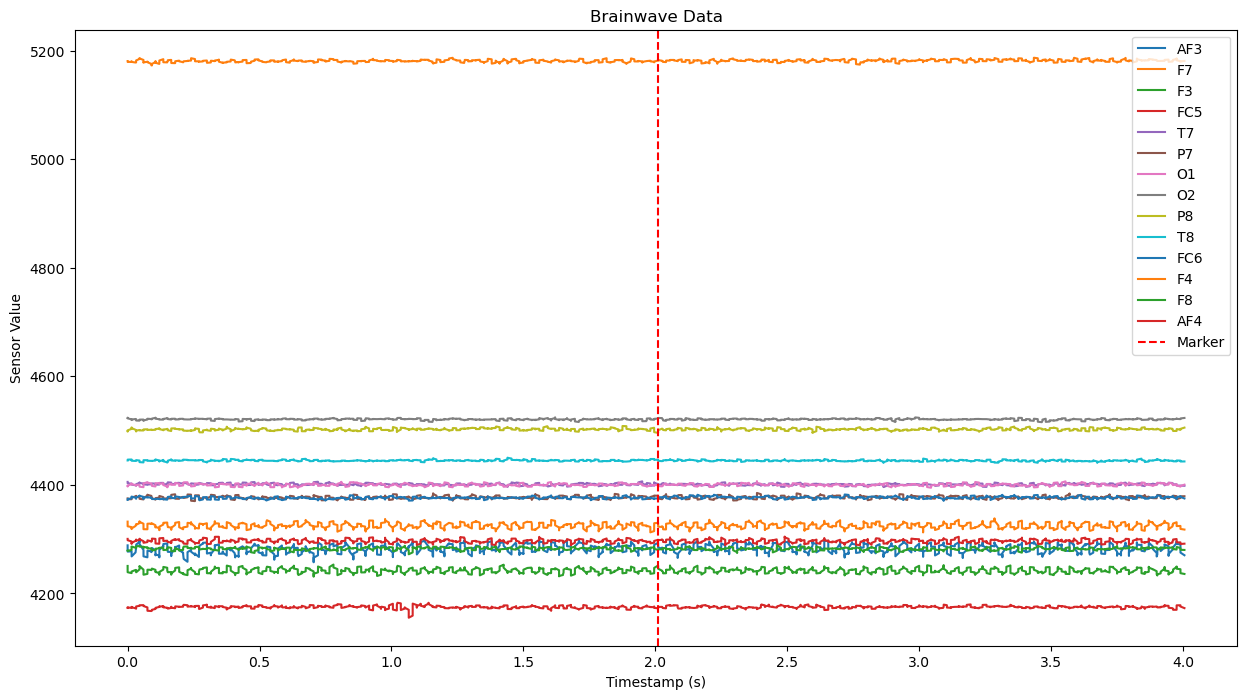

{'0', '1'}


In [8]:
# CSVファイル名を指定
filename = 'test.csv'
#収集するデータの期間（秒）
duration = 4
# 選択したチャンネル名
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

#EEGを収集し、csvファイルに保存
collect_EEG(filename, duration)

#取得したEEGをplot
data = load_data_from_csv(filename)
plot_data_with_marker(data, channels)

In [ ]:
"""
filename1 = ''
data1 = load_data_from_csv(filename1)

filename2 = ''
data2 = load_data_from_csv(filename2)
    
plt.figure(figsize=(20, 10))

# データを平行に２つプロット
plot_data_for_parallel(data1, channels, filename1, 1)
plot_data_for_parallel(data2, channels, filename2, 2)

plt.show()
"""